In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-crossing/items.csv
/kaggle/input/animal-crossing/villagers.csv
/kaggle/input/animal-crossing/user_reviews.csv
/kaggle/input/animal-crossing/critic.csv


# Understanding User Sentiments and Future Desires in Animal Crossing Reviews

# Step-1: Data Loading and Cleaning

In [2]:
df_reviews = pd.read_csv('/kaggle/input/animal-crossing/user_reviews.csv')

In [3]:
df_reviews

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20
...,...,...,...,...
2994,1,TakezoShinmen,1 Island for console limitation.I cannot play ...,2020-05-03
2995,1,Pikey17,"Per giocare con figli o fidanzate, mogli o per...",2020-05-03
2996,0,Lemmeadem,One island per console is a pathetic limitatio...,2020-05-03
2997,2,TandemTester938,Even though it seems like a great game with ma...,2020-05-03


In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   grade      2999 non-null   int64 
 1   user_name  2999 non-null   object
 2   text       2999 non-null   object
 3   date       2999 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.8+ KB


In [5]:
df_reviews.isnull().sum()

grade        0
user_name    0
text         0
date         0
dtype: int64

### Correct date format

In [6]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   grade      2999 non-null   int64         
 1   user_name  2999 non-null   object        
 2   text       2999 non-null   object        
 3   date       2999 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 93.8+ KB


# Step-2: Data Exploration and Preprocessing

## Language Detection

In [8]:
! pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=4e1af53ee046ba8f7b30ea11a725ed9e0e4cd95abfb6c9cc48662869719df4c8
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [9]:
from langdetect import detect

df_reviews['language'] = df_reviews['text'].apply(detect)

In [10]:
df_reviews.language.value_counts()

language
en       2829
es        108
fr         18
pt         11
ru         11
it         10
de          4
pl          2
th          1
so          1
no          1
ko          1
zh-cn       1
fi          1
Name: count, dtype: int64

As majoirity of reviews are in english language. Thus, we can either ignore or translate the respective reviews to english

## Multilingual Translation

### Install Deepl for multilingual translation support

In [11]:
! pip install deepl

## Translate non-english reviews

In [12]:
import deepl

# Replace with your DeepL API key
auth_key = "53ccd28c-8ff3-44e5-9459-7cf4699f0cee:fx"#"your_deepl_api_key"
translator = deepl.Translator(auth_key)

# Translate non-English reviews
def translate_text(text, source_lang, target_lang="EN-GB"):
    try:
        result = translator.translate_text(text, source_lang=source_lang, target_lang=target_lang)
        return result.text
    except Exception as e:
        return f"Translation error: {e}"

# Filter non-English reviews
non_english_reviews = df_reviews[df_reviews['language'] != 'en'].copy()

# Translate non-English reviews
non_english_reviews['translated_text'] = non_english_reviews.apply(
    lambda row: translate_text(row['text'], source_lang=row['language'].upper()), axis=1
)

# Filter English reviews
english_reviews = df_reviews[df_reviews['language'] == 'en']

# Combine English and translated reviews
df_reviews = pd.concat([english_reviews, non_english_reviews], ignore_index=True)



In [13]:
non_english_reviews.translated_text.value_counts()

translated_text
Translation error: Quota for this billing period has been exceeded, message: Quota Exceeded    166
Translation error: Bad request, message: Value for 'source_lang' not supported.                  4
Name: count, dtype: int64

## Combine original and translated text

In [14]:
# Combine original and translated text
df_reviews['final_text'] = df_reviews.apply(
    lambda row: row['text'] if row['language'] == 'en' else row['translated_text'], axis=1
)

In [15]:
df_reviews

,grade,user_name,text,date,language,translated_text,final_text
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20,en,NaN,My gf started playing before me. No option to ...
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20,en,NaN,"While the game itself is great, really relaxin..."
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20,en,NaN,My wife and I were looking forward to playing ...
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20,en,NaN,We need equal values and opportunities for all...
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20,en,NaN,BEWARE! If you have multiple people in your h...
...,...,...,...,...,...,...,...
2994,10,ArisLink,Es el mejor Animal crossing de la historia y m...,2020-04-28,es,Translation error: Quota for this billing peri...,Translation error: Quota for this billing peri...
2995,7,Gemmo,Trovo che il gioco sia ben strutturato e lasci...,2020-04-28,it,Translation error: Quota for this billing peri...,Translation error: Quota for this billing peri...
2996,10,Jhonpo,El juego es maravilloso y que bien esta jugarl...,2020-04-29,es,Translation error: Quota for this billing peri...,Translation error: Quota for this billing peri...
2997,10,Dabaru,Me hacen gracia las notas bajas intentando des...,2020-05-02,es,Translation error: Quota for this billing peri...,Translation error: Quota for this billing peri...


## Filter out rows with translation errors

In [16]:
# Filter out rows with translation errors
df_reviews = df_reviews[~df_reviews['translated_text'].str.contains("Translation error", na=False)]

# Reset the index after filtering
df_reviews.reset_index(drop=True, inplace=True)


In [17]:
df_reviews['translated_text'].str.contains("Translation error", na=False).sum()

0

In [18]:
df_reviews.translated_text.value_counts()

Series([], Name: count, dtype: int64)

In [19]:
df_reviews.shape

(2829, 7)

In [20]:
df_reviews.isnull().sum()

grade                 0
user_name             0
text                  0
date                  0
language              0
translated_text    2829
final_text            0
dtype: int64

In [21]:
df_reviews.columns

Index(['grade', 'user_name', 'text', 'date', 'language', 'translated_text',
       'final_text'],
      dtype='object')

## Final dataset for preprocessing

In [22]:
df_reviews_final = df_reviews[['grade', 'user_name', 'date', 'final_text']]


In [23]:
df_reviews_final

,grade,user_name,date,final_text
0,4,mds27272,2020-03-20,My gf started playing before me. No option to ...
1,5,lolo2178,2020-03-20,"While the game itself is great, really relaxin..."
2,0,Roachant,2020-03-20,My wife and I were looking forward to playing ...
3,0,Houndf,2020-03-20,We need equal values and opportunities for all...
4,0,ProfessorFox,2020-03-20,BEWARE! If you have multiple people in your h...
...,...,...,...,...
2824,0,crazycasti,2020-05-03,For those who say I don't understand review bo...
2825,1,TakezoShinmen,2020-05-03,1 Island for console limitation.I cannot play ...
2826,0,Lemmeadem,2020-05-03,One island per console is a pathetic limitatio...
2827,2,TandemTester938,2020-05-03,Even though it seems like a great game with ma...


## Check grade distribution

<Axes: title={'center': 'Grade Distribution'}, xlabel='grade'>

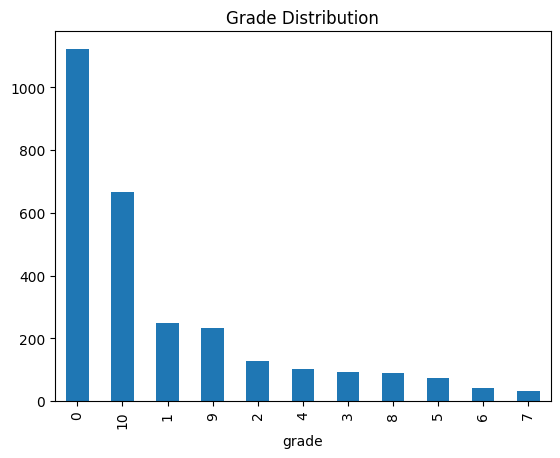

In [24]:
# Grade distribution
df_reviews_final['grade'].value_counts().plot(kind='bar', title='Grade Distribution')

## Word count distribution

<ipython-input-25-509d50a529d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews_final['word_count'] = df_reviews_final['final_text'].str.split().apply(len)


<Axes: title={'center': 'Word Count Distribution'}, ylabel='Frequency'>

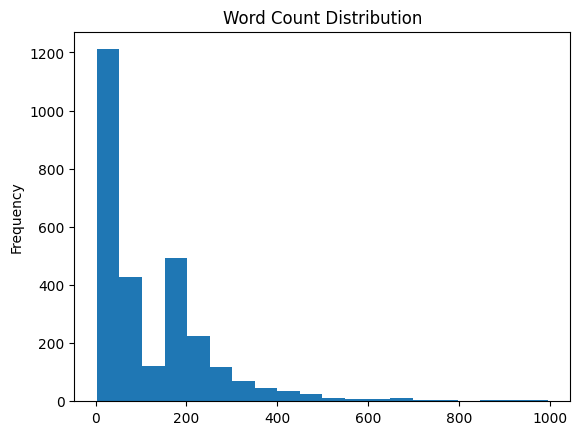

In [25]:
# Word count distribution
df_reviews_final['word_count'] = df_reviews_final['final_text'].str.split().apply(len)
df_reviews_final['word_count'].plot(kind='hist', bins=20, title='Word Count Distribution')

## Text Preprocessing

### Cleaning reviews

In [26]:
import re

def clean_text(text):
    # Remove URLs, HTML tags, and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text.strip()

    
df_reviews_final.loc[:, 'cleaned_text'] = df_reviews_final['final_text'].apply(clean_text)



<ipython-input-26-66fea8d60acb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews_final.loc[:, 'cleaned_text'] = df_reviews_final['final_text'].apply(clean_text)


In [27]:
df_reviews_final

,grade,user_name,date,final_text,word_count,cleaned_text
0,4,mds27272,2020-03-20,My gf started playing before me. No option to ...,70,my gf started playing before me no option to c...
1,5,lolo2178,2020-03-20,"While the game itself is great, really relaxin...",167,while the game itself is great really relaxing...
2,0,Roachant,2020-03-20,My wife and I were looking forward to playing ...,185,my wife and i were looking forward to playing ...
3,0,Houndf,2020-03-20,We need equal values and opportunities for all...,56,we need equal values and opportunities for all...
4,0,ProfessorFox,2020-03-20,BEWARE! If you have multiple people in your h...,183,beware if you have multiple people in your ho...
...,...,...,...,...,...,...
2824,0,crazycasti,2020-05-03,For those who say I don't understand review bo...,18,for those who say i dont understand review bom...
2825,1,TakezoShinmen,2020-05-03,1 Island for console limitation.I cannot play ...,25,1 island for console limitationi cannot play t...
2826,0,Lemmeadem,2020-05-03,One island per console is a pathetic limitatio...,69,one island per console is a pathetic limitatio...
2827,2,TandemTester938,2020-05-03,Even though it seems like a great game with ma...,45,even though it seems like a great game with ma...


## Tokenisation

In [28]:
from nltk.tokenize import word_tokenize

df_reviews_final['tokens'] = df_reviews_final['cleaned_text'].apply(word_tokenize)


In [29]:
df_reviews_final

,grade,user_name,date,final_text,word_count,cleaned_text,tokens
0,4,mds27272,2020-03-20,My gf started playing before me. No option to ...,70,my gf started playing before me no option to c...,"[my, gf, started, playing, before, me, no, opt..."
1,5,lolo2178,2020-03-20,"While the game itself is great, really relaxin...",167,while the game itself is great really relaxing...,"[while, the, game, itself, is, great, really, ..."
2,0,Roachant,2020-03-20,My wife and I were looking forward to playing ...,185,my wife and i were looking forward to playing ...,"[my, wife, and, i, were, looking, forward, to,..."
3,0,Houndf,2020-03-20,We need equal values and opportunities for all...,56,we need equal values and opportunities for all...,"[we, need, equal, values, and, opportunities, ..."
4,0,ProfessorFox,2020-03-20,BEWARE! If you have multiple people in your h...,183,beware if you have multiple people in your ho...,"[beware, if, you, have, multiple, people, in, ..."
...,...,...,...,...,...,...,...
2824,0,crazycasti,2020-05-03,For those who say I don't understand review bo...,18,for those who say i dont understand review bom...,"[for, those, who, say, i, dont, understand, re..."
2825,1,TakezoShinmen,2020-05-03,1 Island for console limitation.I cannot play ...,25,1 island for console limitationi cannot play t...,"[1, island, for, console, limitationi, can, no..."
2826,0,Lemmeadem,2020-05-03,One island per console is a pathetic limitatio...,69,one island per console is a pathetic limitatio...,"[one, island, per, console, is, a, pathetic, l..."
2827,2,TandemTester938,2020-05-03,Even though it seems like a great game with ma...,45,even though it seems like a great game with ma...,"[even, though, it, seems, like, a, great, game..."


## Remove stop words

In [30]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stopwords from tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply to your tokenized column
df_reviews_final['tokens'] = df_reviews_final['tokens'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define model

In [31]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=df_reviews_final['tokens'], vector_size=100, window=5, min_count=1)
word_vectors = model.wv


## Check word similarity

In [32]:
# Check the most similar words for a given word
similar_words = word_vectors.most_similar('improve', topn=10)
print(similar_words)


[('either', 0.9974322319030762), ('choose', 0.9968093633651733), ('annoying', 0.9967028498649597), ('instead', 0.9965804219245911), ('awful', 0.9963663816452026), ('split', 0.9961092472076416), ('impact', 0.9961041808128357), ('90', 0.996071994304657), ('ability', 0.9959425330162048), ('caused', 0.9958658218383789)]


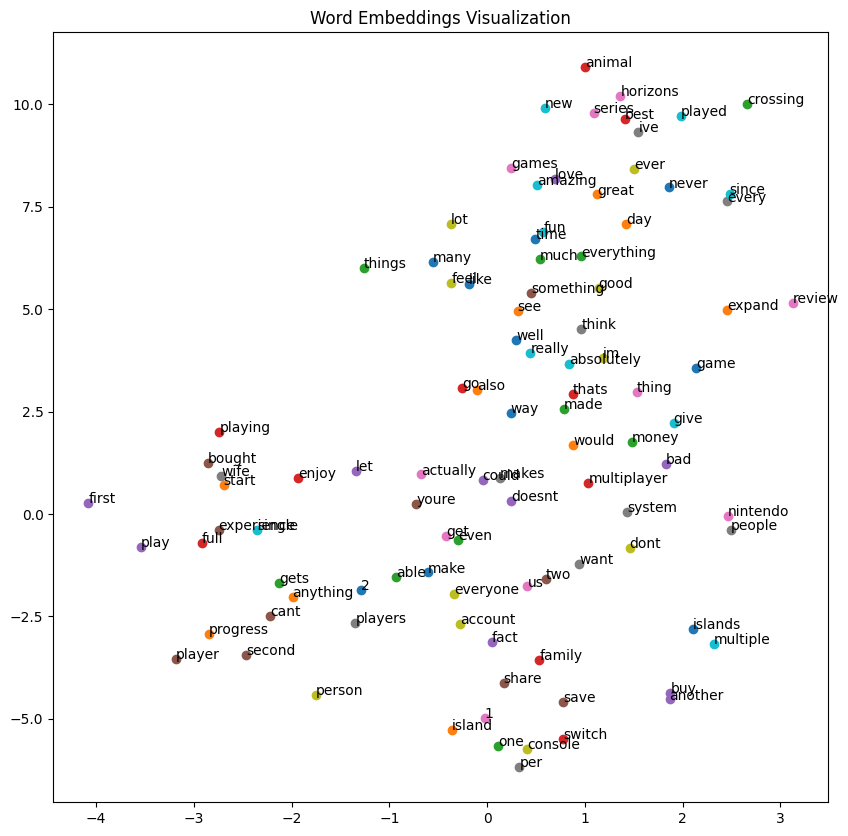

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get word vectors and their corresponding words
words = list(model.wv.index_to_key)
word_vectors = model.wv[words]

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(word_vectors[:100])  # Use the first 100 words for visualization

# Plot the embeddings
plt.figure(figsize=(10, 10))
for i, word in enumerate(words[:100]):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word)
plt.title("Word Embeddings Visualization")
plt.show()



* Clustering:
    * Words that are semantically or contextually similar are placed closer together.
        * For example:Words like animal, crossing, and game may cluster near each other if they frequently appear in similar contexts in the reviews.
* Spread:
    * Common words like the, is, and may be scattered because they don't carry much contextual meaning (stopwords).
    * We might consider removing them for certain tasks.

* Domain-Specific Relationships:
    * Words like multiplayer, Nintendo, and games likely form a distinct cluster related to gaming concepts



In [34]:
import numpy as np

def get_review_vector(review_tokens, model):
    vectors = [model.wv[word] for word in review_tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average the vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are in the model

df_reviews_final['review_vector'] = df_reviews_final['tokens'].apply(lambda x: get_review_vector(x, model))


In [35]:
df_reviews_final

,grade,user_name,date,final_text,word_count,cleaned_text,tokens,review_vector
0,4,mds27272,2020-03-20,My gf started playing before me. No option to ...,70,my gf started playing before me no option to c...,"[gf, started, playing, option, create, island,...","[-0.44274276, 0.8890168, 0.29076788, 0.294471,..."
1,5,lolo2178,2020-03-20,"While the game itself is great, really relaxin...",167,while the game itself is great really relaxing...,"[game, great, really, relaxing, gorgeous, cant...","[-0.42564285, 0.9105627, 0.24217238, 0.3019949..."
2,0,Roachant,2020-03-20,My wife and I were looking forward to playing ...,185,my wife and i were looking forward to playing ...,"[wife, looking, forward, playing, game, releas...","[-0.47513074, 0.9097772, 0.27772272, 0.2292500..."
3,0,Houndf,2020-03-20,We need equal values and opportunities for all...,56,we need equal values and opportunities for all...,"[need, equal, values, opportunities, players, ...","[-0.38507497, 0.7987896, 0.2778269, 0.20202516..."
4,0,ProfessorFox,2020-03-20,BEWARE! If you have multiple people in your h...,183,beware if you have multiple people in your ho...,"[beware, multiple, people, house, want, play, ...","[-0.45172697, 1.002754, 0.25560942, 0.40386555..."
...,...,...,...,...,...,...,...,...
2824,0,crazycasti,2020-05-03,For those who say I don't understand review bo...,18,for those who say i dont understand review bom...,"[say, dont, understand, review, bombing, well,...","[-0.27330008, 0.79044384, 0.11075065, 0.076506..."
2825,1,TakezoShinmen,2020-05-03,1 Island for console limitation.I cannot play ...,25,1 island for console limitationi cannot play t...,"[1, island, console, limitationi, play, game, ...","[-0.54184663, 0.8971857, 0.24110292, 0.1960254..."
2826,0,Lemmeadem,2020-05-03,One island per console is a pathetic limitatio...,69,one island per console is a pathetic limitatio...,"[one, island, per, console, pathetic, limitati...","[-0.32197064, 0.72512394, 0.19415778, 0.315211..."
2827,2,TandemTester938,2020-05-03,Even though it seems like a great game with ma...,45,even though it seems like a great game with ma...,"[even, though, seems, like, great, game, many,...","[-0.35049886, 0.8495273, 0.22013569, 0.2208048..."


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Create review-level vectors
X = np.stack(df_reviews_final['review_vector'].values)
y = df_reviews_final['grade'].apply(lambda g: 1 if g >= 6 else 0)  # Positive sentiment: grade >= 6

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train sentiment classifier
model_logis = LogisticRegression()
model_logis.fit(X_train, y_train)

# Evaluate model
predictions = model_logis.predict(X_test)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

           0       0.85      0.91      0.88       372
           1       0.80      0.70      0.74       194

    accuracy                           0.84       566
   macro avg       0.83      0.80      0.81       566
weighted avg       0.83      0.84      0.83       566

0.8356890459363958


In [37]:
from sklearn.cluster import KMeans

# Apply KMeans clustering on word vectors
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(word_vectors[:100])  # Use the first 100 words for simplicity

# Get cluster labels for words
clusters = kmeans.labels_

# Print words grouped by cluster
from collections import defaultdict
cluster_map = defaultdict(list)
for idx, label in enumerate(clusters):
    cluster_map[label].append(words[idx])

for cluster_id, word_list in cluster_map.items():
    print(f"Cluster {cluster_id}: {word_list}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: ['game', 'nintendo', 'people', 'dont', 'really', 'would', 'playing', 'want', 'im', 'multiplayer', 'could', 'way', 'also', 'enjoy', 'bought', 'made', 'thing', 'system', 'give', 'doesnt', 'think', 'thats', 'bad', 'well', 'money', 'go', 'let', 'actually', 'makes', 'absolutely']
Cluster 1: ['island', 'one', 'switch', 'per', 'console', 'buy', '1', 'person', 'multiple', 'family', 'another', 'share', 'islands', 'fact', 'save']
Cluster 2: ['play', 'player', 'first', 'cant', 'get', 'even', 'experience', 'make', 'second', 'players', 'progress', 'able', 'everyone', '2', 'gets', 'full', 'two', 'account', 'single', 'anything', 'youre', 'us', 'wife', 'start']
Cluster 4: ['new', 'crossing', 'animal', 'played', 'series', 'ive', 'best', 'horizons']
Cluster 3: ['like', 'expand', 'time', 'games', 'fun', 'great', 'much', 'things', 'review', 'every', 'good', 'love', 'lot', 'since', 'many', 'day', 'see', 'never', 'everything', 'ever', 'amazing', 'something', 'feel']


In [38]:
similar_words = model.wv.most_similar('multiplayer', topn=5)
print("Words similar to 'multiplayer':", similar_words)

Words similar to 'multiplayer': [('terrible', 0.9945522546768188), ('affect', 0.9934331774711609), ('issue', 0.9927616715431213), ('unplayable', 0.9915501475334167), ('allowing', 0.9912160038948059)]
